In [1]:
import numpy as np
import matplotlib.pyplot as plt
from few.waveform import GenerateEMRIWaveform, FastSchwarzschildEccentricFlux, FastKerrEccentricEquatorialFlux
from few.utils.constants import Gpc, MRSUN_SI, YRSID_SI
from typing import Optional, Union, Callable
from tqdm import tqdm

#try:
#    import cupy as cp
#    use_gpu = True
#except ImportError():
#    print("Not on GPU")
#    use_gpu = False

use_gpu = True

from stableemrifisher.fisher.fisher import StableEMRIFisher
from stableemrifisher.utils import inner_product

from fastlisaresponse import ResponseWrapper  # Response function 
from lisatools.detector import ESAOrbits #ESAOrbits correspond to esa-trailing-orbits.h5
from lisatools.sensitivity import get_sensitivity, A1TDISens, E1TDISens, T1TDISens

if not use_gpu:
    
    import few
    
    #tune few configuration
    cfg_set = few.get_config_setter(reset=True)
    
    cfg_set.enable_backends("cpu")
    cfg_set.set_log_level("info");
    force_backend = 'cpu'
else:
    force_backend = 'gpu'
    pass #let the backend decide for itself.

startup


In [2]:
#waveform class setup
waveform_class = FastSchwarzschildEccentricFlux
waveform_class_kwargs = dict(inspiral_kwargs=dict(err=1e-11,),
                             mode_selector_kwargs=dict(mode_selection_threshold=1e-5))

#waveform generator setup
waveform_generator = GenerateEMRIWaveform
waveform_generator_kwargs = dict(return_list=False)

#ResponseWrapper setup
ResponseWrapper = ResponseWrapper
tdi_gen ="1st generation"# "2nd generation"#
order = 20  # interpolation order (should not change the result too much)
tdi_kwargs_esa = dict(
    orbits=ESAOrbits(use_gpu=use_gpu), order=order, tdi=tdi_gen, tdi_chan="AE",
)  # could do "AET"
index_lambda = 8
index_beta = 7
# with longer signals we care less about this
t0 = 10000.0  # throw away on both ends when our orbital information is weird
T = 0.1
dt = 10.0

ResponseWrapper_kwargs = dict(
    #waveform_gen=waveform_generator,
    Tobs = T,
    dt = dt,
    index_lambda = index_lambda,
    index_beta = index_beta,
    t0 = t0,
    flip_hx = True,
    use_gpu=use_gpu,
    is_ecliptic_latitude=False,
    remove_garbage="zero",
    **tdi_kwargs_esa
)

#noise setup
channels = [A1TDISens, E1TDISens]
noise_model = get_sensitivity
noise_kwargs = [{"sens_fn": channel_i} for channel_i in channels]

In [3]:
sef = StableEMRIFisher(waveform_class=waveform_class, 
                       waveform_class_kwargs=waveform_class_kwargs,
                       waveform_generator=waveform_generator,
                       waveform_generator_kwargs=waveform_generator_kwargs,
                       ResponseWrapper=ResponseWrapper, ResponseWrapper_kwargs=ResponseWrapper_kwargs,
                       noise_model=noise_model, noise_kwargs=noise_kwargs, channels=channels,
                      stats_for_nerds = True, use_gpu = use_gpu,
                      deriv_type='stable')

Body is not plunging, Fisher should be stable.
wave ndim: 2
Computing SNR for parameters: {'m1': 1000000.0, 'm2': 10.0, 'a': 0.0, 'p0': 9.5, 'e0': 0.4, 'xI0': 1.0, 'dist': 0.1, 'qS': 1.0471975511965976, 'phiS': 0.7853981633974483, 'qK': 0.5235987755982988, 'phiK': 0.39269908169872414, 'Phi_phi0': 1.0, 'Phi_theta0': 0.0, 'Phi_r0': 0.0}
Waveform Generated. SNR: 119.32881779777304
calculating stable deltas...


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m1: 28.1149290717494


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m1: 4.543518252849421


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m1: 28.114929072134423


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m1: 28.114929066866488


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m1: 28.114929026806376


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m1: 28.114928777931727


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m1: 28.114930704520496


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m1: 4.5435178711574284
[np.float64(5.1879203531574705), np.float64(0.838394817173747), np.float64(1.8737146406050254e-10), np.float64(1.4248697421270697e-09), np.float64(8.852046215556859e-09), np.float64(6.852546746977311e-08), np.float64(5.187921232355233)]
2


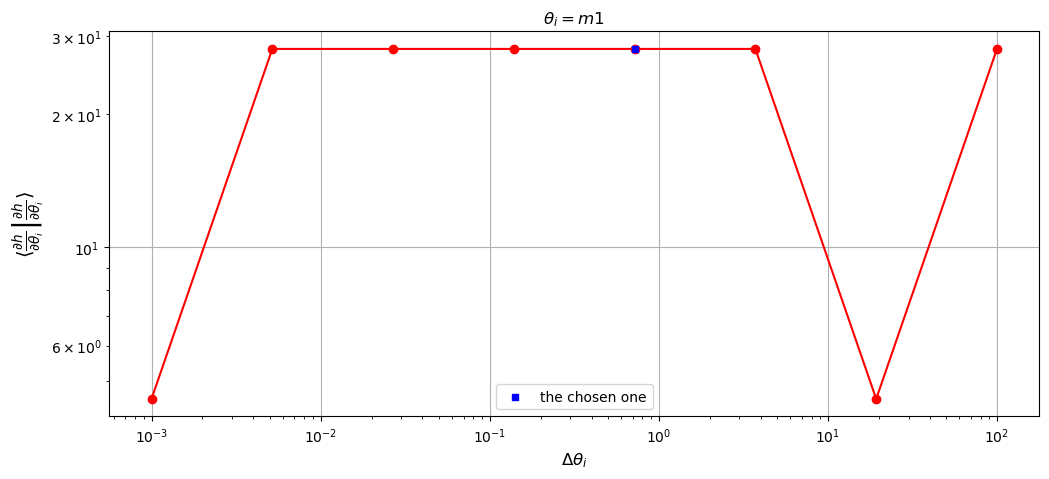

(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m2: 1779409.983164526


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m2: 1779409.9819995353


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m2: 1779409.9819699423


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m2: 32669248.574932434


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m2: 1779409.9780253458


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m2: 1779409.9587143133


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m2: 32669249.62423703


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for m2: 1779410.6205012035
[np.float64(6.547061789467219e-10), np.float64(1.663079781439057e-11), np.float64(0.945532570855171), np.float64(17.35959614612608), np.float64(1.0852492083812825e-08), np.float64(0.9455325733164626), np.float64(17.359590106883335)]
1


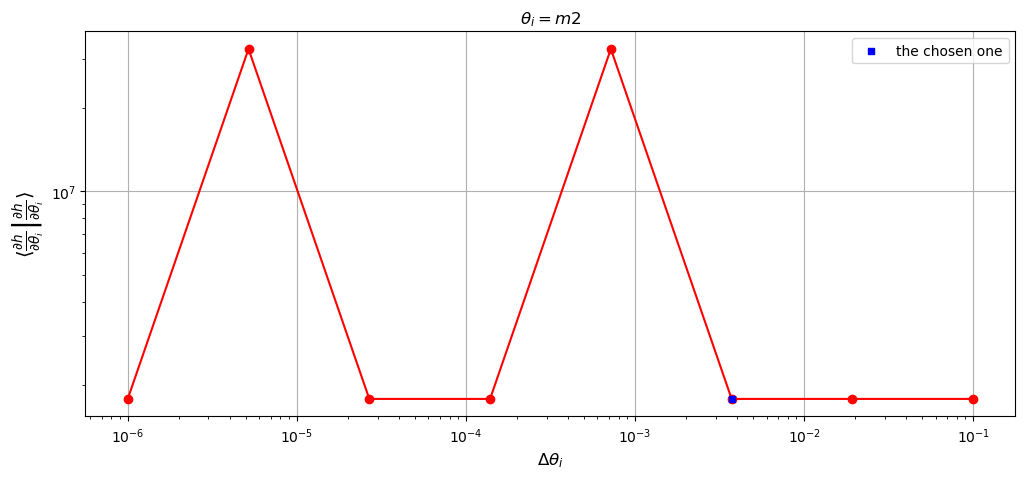

(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for p0: 512111249543.295


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for p0: 512111579096.80774


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for p0: 512111594175.16785


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for p0: 512111601644.52277


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for p0: 512111394576.07605


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for p0: 512111833290.4728


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for p0: 512109188630.00916


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for p0: 512135295780.2398
[np.float64(6.435189638507471e-07), np.float64(2.944350465587061e-08), np.float64(1.4585404617758245e-08), np.float64(4.043425881740419e-07), np.float64(8.566769369683249e-07), np.float64(5.16425114475689e-06), np.float64(5.0977057128775956e-05)]
2


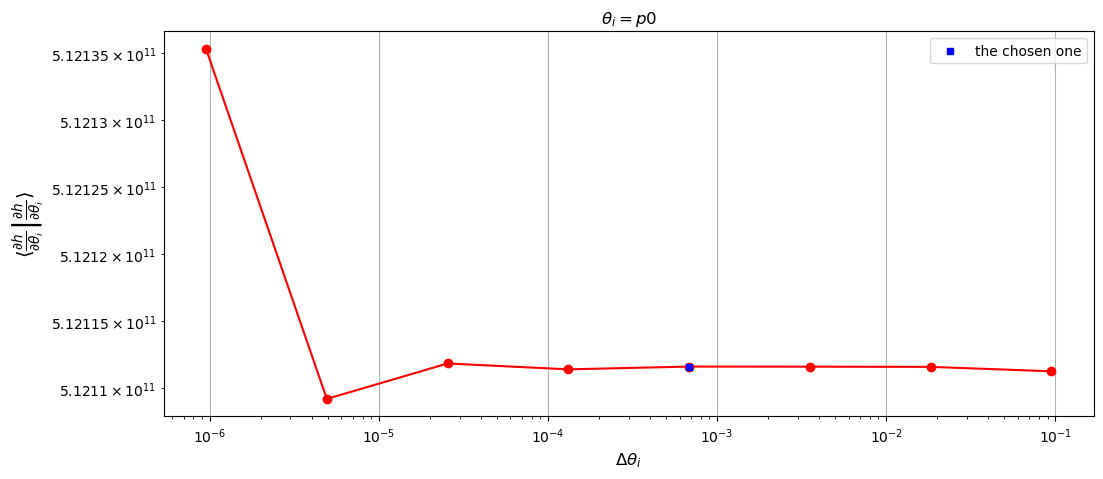

(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for e0: 27018170869523.633


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for e0: 27018024357314.49


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for e0: 27018030363471.926


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for e0: 27018033928011.87


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for e0: 27018058422749.02


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for e0: 27018037518378.01


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for e0: 27017516929836.504


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


Gamma_ii for e0: 27015511357569.043
[np.float64(5.4227580524357085e-06), np.float64(2.2230182425215784e-07), np.float64(1.3193187760478904e-07), np.float64(9.066061211790519e-07), np.float64(7.737190753989101e-07), np.float64(1.9268556131925883e-05), np.float64(7.423780512298274e-05)]
2


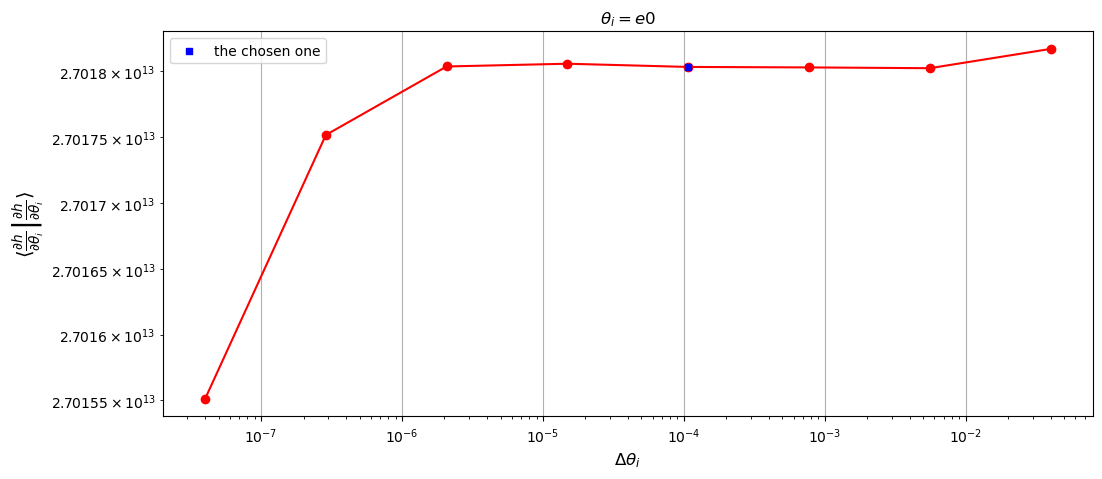

Gamma_ii for qS: 96585.30134625082
Gamma_ii for qS: 91147.37690213064
Gamma_ii for qS: 91176.54982651686
Gamma_ii for qS: 91177.8927289487
Gamma_ii for qS: 91176.5691060597
Gamma_ii for qS: 91177.20657241328
Gamma_ii for qS: 91177.7660258392
Gamma_ii for qS: 91172.47971993203
[np.float64(0.05966078925078833), np.float64(0.0003199608281046913), np.float64(1.472837758861945e-05), np.float64(1.4517138580441324e-05), np.float64(6.9915100225876e-06), np.float64(6.135853621987764e-06), np.float64(5.798137687388311e-05)]
5


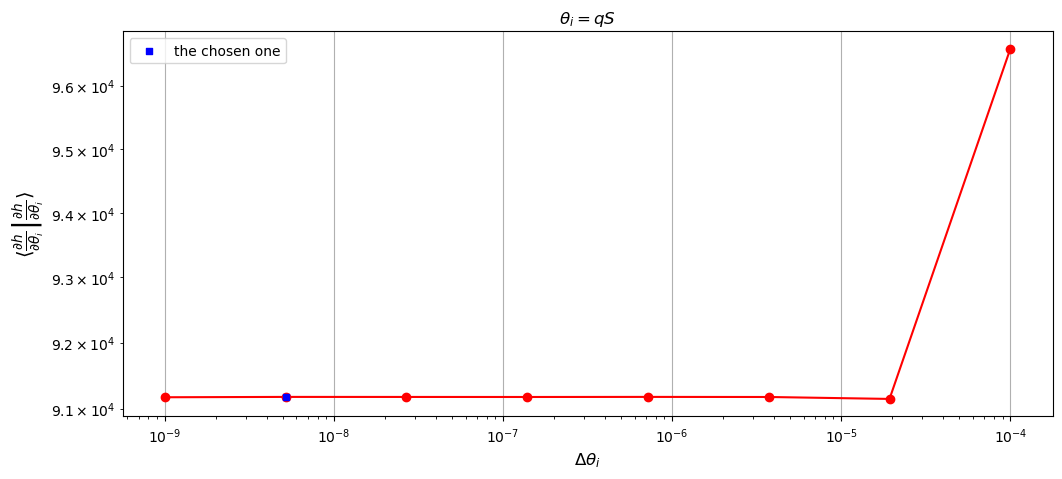

Gamma_ii for phiS: 519519.8691678214
Gamma_ii for phiS: 519585.8489719007
Gamma_ii for phiS: 519610.24318203115
Gamma_ii for phiS: 519633.551535536
Gamma_ii for phiS: 519630.4035221679
Gamma_ii for phiS: 519647.8301139524
Gamma_ii for phiS: 519645.538558582
Gamma_ii for phiS: 519657.5597019951
[np.float64(0.00012698537539048598), np.float64(4.694713095156612e-05), np.float64(4.4855366702145134e-05), np.float64(6.058177787124473e-06), np.float64(3.353538834309621e-05), np.float64(4.4098432495643105e-06), np.float64(2.3132817349918485e-05)]
5


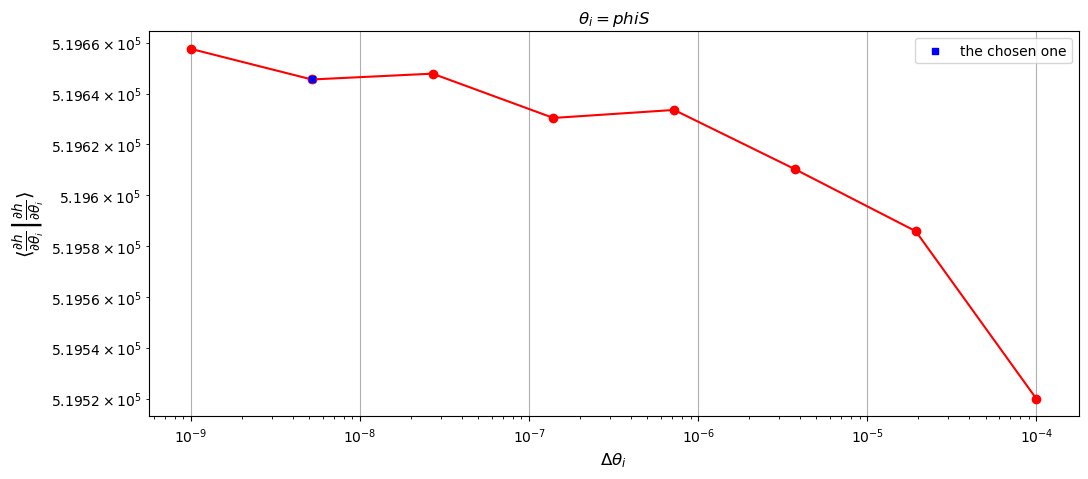

Gamma_ii for qK: 70848.02856533525
Gamma_ii for qK: 70848.02856446561
Gamma_ii for qK: 70848.02856987927
Gamma_ii for qK: 70848.02859857949
Gamma_ii for qK: 70848.0285152599
Gamma_ii for qK: 70848.02872327022
Gamma_ii for qK: 70848.02480672466
Gamma_ii for qK: 70848.01471856063
[np.float64(1.227468178837378e-11), np.float64(7.641231266694052e-11), np.float64(4.0509551364616466e-10), np.float64(1.1760326600322288e-09), np.float64(2.9360072999088493e-09), np.float64(5.5280942242497286e-08), np.float64(1.423916261409962e-07)]
0


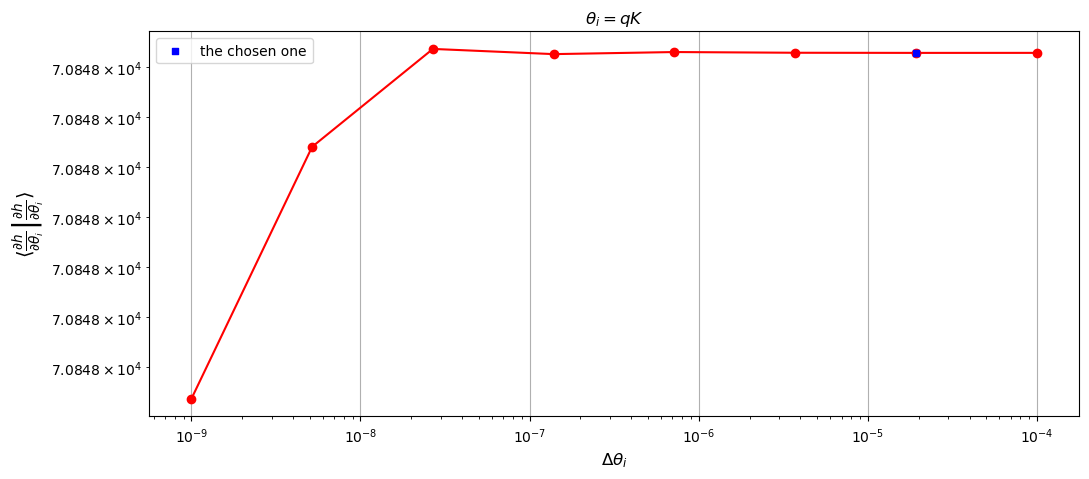

Gamma_ii for phiK: 30630.41057279761
Gamma_ii for phiK: 30630.41057291279
Gamma_ii for phiK: 30630.410570660293
Gamma_ii for phiK: 30630.410581363303
Gamma_ii for phiK: 30630.41063991611
Gamma_ii for phiK: 30630.410598741593
Gamma_ii for phiK: 30630.412910974417
Gamma_ii for phiK: 30630.40845253788
[np.float64(3.760382079670489e-12), np.float64(7.353797067004064e-11), np.float64(3.4942430887723336e-10), np.float64(1.9115906595300213e-09), np.float64(1.3442365284877165e-09), np.float64(7.548813757807627e-08), np.float64(1.455558957239027e-07)]
0


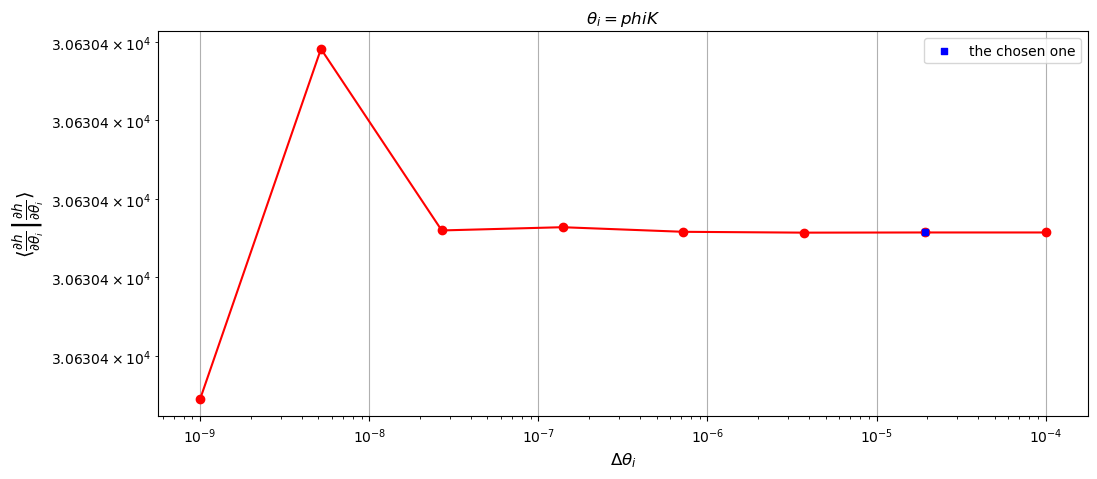

stable deltas: {'m1': 0.7196856730011522, 'm2': 0.003727593720314938, 'p0': 0.000683701389351095, 'e0': 0.00010730783181118912, 'dist': 0.0, 'qS': 5.179474679231223e-09, 'phiS': 5.179474679231223e-09, 'qK': 1.9306977288832496e-05, 'phiK': 1.9306977288832496e-05, 'Phi_phi0': 0.0, 'Phi_r0': 0.0}
Time taken to compute stable deltas is 276.8354711532593 seconds
calculating Fisher matrix...


(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providi

Finished derivatives
Calculated Fisher is *atleast* positive-definite.
Time taken to compute FM is 39.4172842502594 seconds


In [4]:
m1 = 1e6
m2 = 1e1
a = 0.
p0 = 9.5
e0 = 0.4
xI0 = 1.0
dist = 0.1
qS = np.pi/3
phiS = np.pi/4
qK = np.pi/6
phiK = np.pi/8
Phi_phi0 = 1.0
Phi_theta0 = 0.0
Phi_r0 = 0.0

pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
param_names = ['m1','m2','p0','e0','dist','qS','phiS','qK','phiK','Phi_phi0','Phi_r0']

der_order = 4
Ndelta = 8
stability_plot = True

delta_range = dict(
    m1 = np.geomspace(1e-4*m1, 1e-9*m1, Ndelta),
    m2 = np.geomspace(1e-2*m2, 1e-7*m2, Ndelta),
    p0 = np.geomspace(1e-2*p0, 1e-7*p0, Ndelta),
    e0 = np.geomspace(1e-1*e0, 1e-7*e0, Ndelta),
    qS = np.geomspace(1e-4,    1e-9,    Ndelta),
    phiS = np.geomspace(1e-4,    1e-9,    Ndelta),
    qK = np.geomspace(1e-4,    1e-9,    Ndelta),
    phiK = np.geomspace(1e-4,    1e-9,    Ndelta),
)

Fisher = sef(*pars_list, param_names = param_names, 
             T = T, dt = dt, 
             der_order = der_order, 
             Ndelta = Ndelta, 
             stability_plot = stability_plot,
             delta_range = delta_range,
            live_dangerously = False)

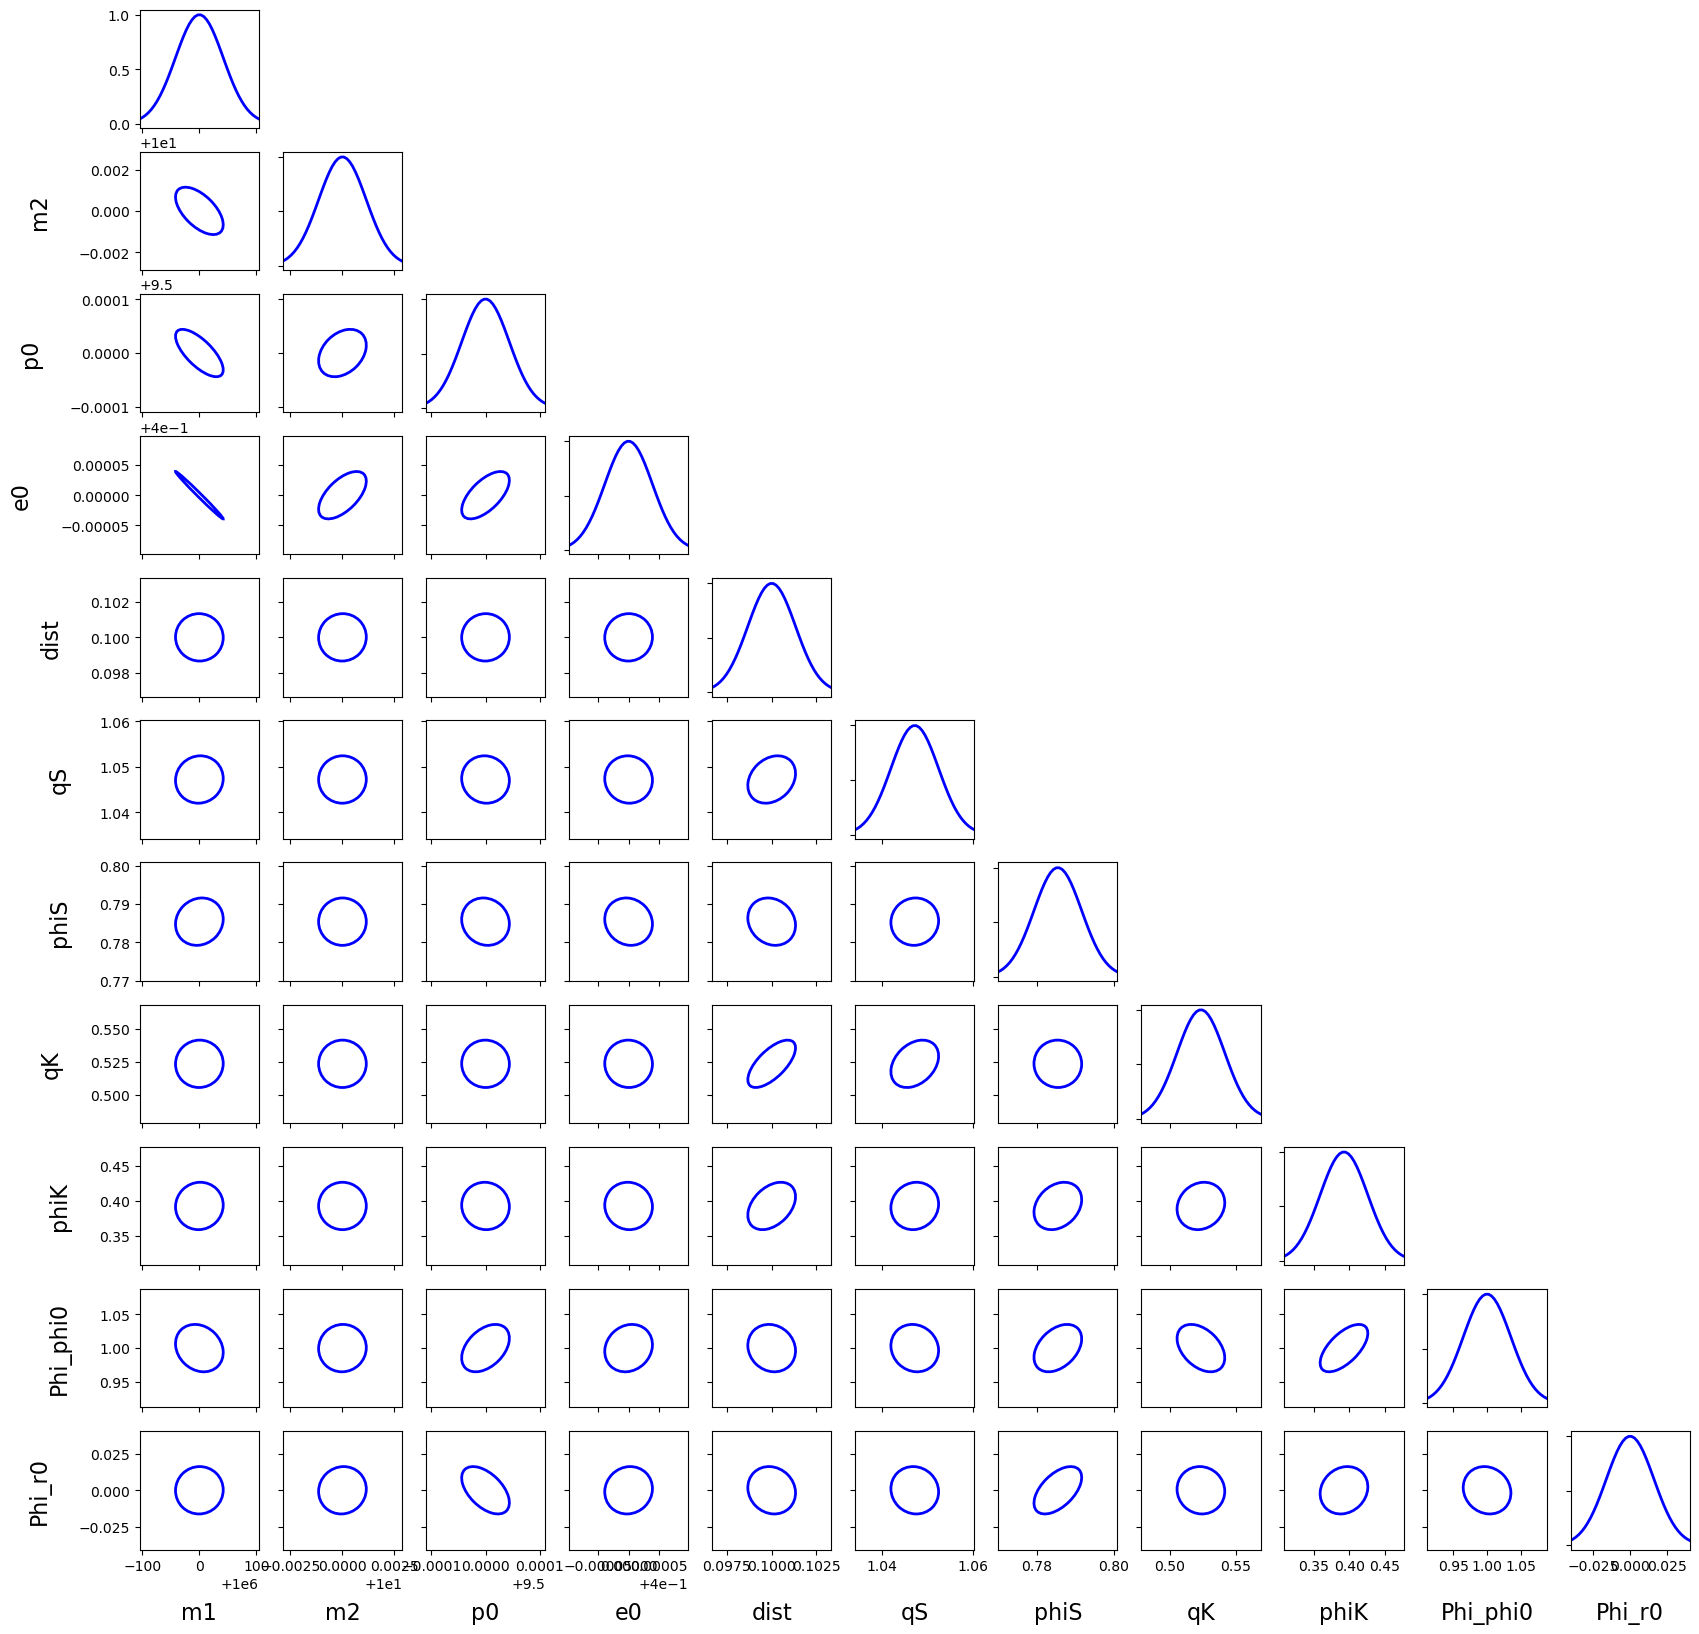

In [5]:
from stableemrifisher.plot import CovEllipsePlot

pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
pars_name = ['m1','m2','a','p0','e0','xI0','dist','qS','phiS','qK','phiK','Phi_phi0','Phi_theta0','Phi_r0']

wave_params = {}
for i in range(len(pars_list)):
    wave_params[pars_name[i]] = pars_list[i]
    
param_names = param_names

covariance = np.linalg.inv(Fisher)

ellipse_kwargs = dict(facecolor='None', edgecolor='b', lw=2)
line_kwargs = dict(lw=2, color='b')

fig, axs = plt.subplots(len(covariance),len(covariance), figsize=(20,20))
fig, axs = CovEllipsePlot(covariance, wave_params=wave_params, param_names=param_names, fig=fig, axs=axs, ellipse_kwargs=ellipse_kwargs, line_kwargs=line_kwargs)